In [3]:
import warnings
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor # 다중공선성 패키지 불러오기
from sklearn.linear_model import LinearRegression # sklearn 선형회귀 모형 -> 변수 선택법을 위함
from sklearn.feature_selection import RFE # 변수 선택법 (후진 제거법)
from sklearn.preprocessing import scale # 데이터 scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.neighbors import KNeighborsClassifier
warnings.filterwarnings('ignore')
%matplotlib inline
matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus']=False
ds_hmeq = pd.read_csv("./HMEQ.CSV",engine="python")
ds_hmeq.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1700,30548,40320.0,HomeImp,Other,9.0,0,0.0,101.466002,1.0,8,37.113614
1,1,1800,28502,43034.0,HomeImp,Other,11.0,0,0.0,88.766030,0.0,8,36.884894
2,0,2300,102370,120953.0,HomeImp,Office,2.0,0,0.0,90.992533,0.0,13,31.588503
3,1,2400,34863,47471.0,HomeImp,Mgr,12.0,0,0.0,70.491080,1.0,21,38.263601
4,0,2400,98449,117195.0,HomeImp,Office,4.0,0,0.0,93.811775,0.0,13,29.681827


In [6]:
ds_hmeq.isnull().sum()
# JOB의 결측치는 Other로 메꾼 후에 ds_hmeq데이터에 저장. inplace=false:저장안함
ds_hmeq["JOB"].fillna("Other", inplace=True)
# 숫자변수 결측치 mean으로 각 변수별 평균 계산 후 결측치 대체 
ds_hmeq.fillna(ds_hmeq.mean(),inplace=True)

ds_hmeq_dummy = pd.get_dummies(ds_hmeq)
# 데이터 분할(train, test 데이터 7:3으로 - numpy->random)
np.random.seed(seed=1234)

# 0.7보다 작으면 True -> train 데이터, 아니면 False -> test 데이터
msk = np.random.rand(ds_hmeq_dummy.shape[0]) < 0.7
ds_hmeq_train = ds_hmeq_dummy[msk]
ds_hmeq_test = ds_hmeq_dummy[~msk]

# train/test 데이터의 목표변수/설명변수 지정
ds_hmeq_train_y = ds_hmeq_train["BAD"]
ds_hmeq_train_x = ds_hmeq_train.drop("BAD", axis=1, inplace=False)
ds_hmeq_test_y = ds_hmeq_test["BAD"]
ds_hmeq_test_x = ds_hmeq_test.drop("BAD", axis=1, inplace=False)


In [7]:
knn_uncustomized = KNeighborsClassifier()
knn_uncustomized

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [8]:
knn_uncustomized.fit(ds_hmeq_train_x,ds_hmeq_train_y)
# test 데이터로 예측
y_pred = knn_uncustomized.predict(ds_hmeq_test_x)
print("predict test set: {}".format(y_pred.tolist()[:10]))
print("test set label: {}".format(ds_hmeq_test_y.tolist()[:10]))
print("accuracy: {0:.3f}".format(knn_uncustomized.score(ds_hmeq_test_x,ds_hmeq_test_y)))

predict test set: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
test set label: [1, 0, 1, 1, 0, 0, 1, 0, 0, 0]
accuracy: 0.909


In [9]:
# 최대 아웃 수
max_n_neighbors = 10 
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]
train_accuracy = []
test_accuracy = []
# 반복문
for n_neighbors in para_n_neighbors:
    # 이웃 1~10개까지 지정해 모델 생성
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# DataFrame 변환
ds_neighbors = pd.DataFrame()
ds_neighbors["Neighbors"] = para_n_neighbors
ds_neighbors["TrainAccuracy"] = train_accuracy
ds_neighbors["TestAccuracy"] = test_accuracy
ds_neighbors

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000000,0.875874
1,2,0.928955,0.910839
2,3,0.932412,0.907343
3,4,0.914747,0.909091
4,5,0.915515,0.909091
5,6,0.910522,0.909965
6,7,0.910906,0.909965
7,8,0.909754,0.909965
8,9,0.909370,0.910839
9,10,0.907834,0.909965


# 군집이 1개일 때 train 데이터의 정확도는 1
# 군집이 2개일 때 test 데이터의 정확도가 증가, train데이터 정확도 감소

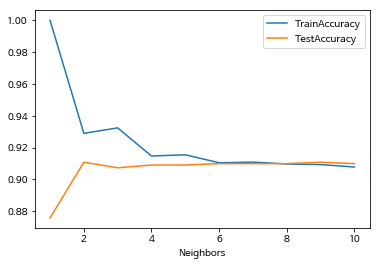

In [10]:
ds_neighbors.set_index("Neighbors",inplace=False).plot()

In [12]:
max_n_neighbors =  10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)]*2
para_weights = ["uniform"]*max_n_neighbors+["distance"]*max_n_neighbors
train_accuracy =  []
test_accuracy = []
# 트리 최대수(1~30)별로 랜덤 포레스트 모델 생성 및 정확도값 저장
for (n_neighbors, weights) in zip (para_n_neighbors,para_weights):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors,weights=weights)
    clf.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_neighbors_weight = pd.DataFrame()
ds_neighbors_weight["Neighbors"] = para_n_neighbors
ds_neighbors_weight["Weights"] = para_weights
ds_neighbors_weight["TrainAccuracy"]=train_accuracy
ds_neighbors_weight["TestAccuracy"]=test_accuracy
ds_neighbors_weight

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000000,0.875874
1,2,uniform,0.928955,0.910839
2,3,uniform,0.932412,0.907343
3,4,uniform,0.914747,0.909091
4,5,uniform,0.915515,0.909091
5,6,uniform,0.910522,0.909965
6,7,uniform,0.910906,0.909965
7,8,uniform,0.909754,0.909965
8,9,uniform,0.909370,0.910839
9,10,uniform,0.907834,0.909965


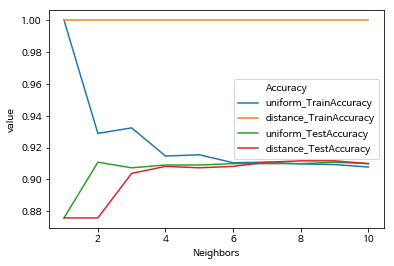

In [20]:
# melt method: 데이터를 재구성하는 함수로 id_vars를 기준으로 transpose
ds_neighbors_weight_melt = pd.melt(ds_neighbors_weight, id_vars=["Neighbors","Weights"])
ds_neighbors_weight_melt["Accuracy"] = ds_neighbors_weight_melt["Weights"] + "_" + ds_neighbors_weight_melt["variable"]
ax = sns.lineplot(x="Neighbors", y="value", hue="Accuracy",data=ds_neighbors_weight_melt)

In [22]:
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)] * 3
# 알고리즘 (ball_tree, kd_tree, brute)
para_algorithm = ["ball_tree"] * max_n_neighbors + ["kd_tree"] * max_n_neighbors + ["brute"] * max_n_neighbors
train_accuracy = []
test_accuracy = []

for(n_neighbors, algorithm) in zip (para_n_neighbors, para_algorithm):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors,weights="uniform",algorithm=algorithm)
    clf.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_neighbors_algorithm = pd.DataFrame()
ds_neighbors_algorithm["Neighbors"] = para_n_neighbors
ds_neighbors_algorithm["Algorithm"] = para_algorithm
ds_neighbors_algorithm["TrainAccuracy"]=train_accuracy
ds_neighbors_algorithm["TestAccuracy"]=test_accuracy
ds_neighbors_algorithm

,Neighbors,Algorithm,TrainAccuracy,TestAccuracy
0,1,ball_tree,1.000000,0.875874
1,2,ball_tree,0.928955,0.910839
2,3,ball_tree,0.932412,0.907343
3,4,ball_tree,0.914747,0.909091
4,5,ball_tree,0.915515,0.909091
5,6,ball_tree,0.910522,0.909965
6,7,ball_tree,0.910906,0.909965
7,8,ball_tree,0.909754,0.909965
8,9,ball_tree,0.909370,0.910839
9,10,ball_tree,0.907834,0.909965


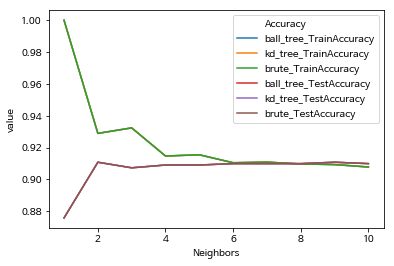

In [23]:
# melt method: 데이터를 재구성하는 함수로 id_vars를 기준으로 transpose
ds_neighbors_weight_melt = pd.melt(ds_neighbors_algorithm,id_vars=["Neighbors","Algorithm"])
ds_neighbors_weight_melt["Accuracy"] = ds_neighbors_weight_melt["Algorithm"] + "_" + ds_neighbors_weight_melt["variable"]
ax = sns.lineplot(x="Neighbors",y="value",hue="Accuracy",data=ds_neighbors_weight_melt)

In [30]:
max_n_neighbors = 10
para_n_neighbors = [i+1 for i in range(max_n_neighbors)] * 3
# 알고리즘 (ball_tree, kd_tree, brute)
para_metric = ["minkowski"] * max_n_neighbors + ["euclidean"] * max_n_neighbors + ["manhattan"] * max_n_neighbors
train_accuracy = []
test_accuracy = []

for(n_neighbors, metric) in zip (para_n_neighbors, para_metric):
    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights="uniform",algorithm = "ball_tree", metric = metric)
    clf.fit(ds_hmeq_train_x,ds_hmeq_train_y)
    train_accuracy.append(clf.score(ds_hmeq_train_x,ds_hmeq_train_y))
    test_accuracy.append(clf.score(ds_hmeq_test_x,ds_hmeq_test_y))
# 저장된 모델의 train/ test 데이터 분류 정확도 테이블 생성
ds_neighbors_metric = pd.DataFrame()
ds_neighbors_metric["Neighbors"] = para_n_neighbors
ds_neighbors_metric["Metric"] = para_algorithm
ds_neighbors_metric["TrainAccuracy"]=train_accuracy
ds_neighbors_metric["TestAccuracy"]=test_accuracy
ds_neighbors_metric

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000000,0.875874
1,2,minkowski,0.928955,0.910839
2,3,minkowski,0.932412,0.907343
3,4,minkowski,0.914747,0.909091
4,5,minkowski,0.915515,0.909091
5,6,minkowski,0.910522,0.909965
6,7,minkowski,0.910906,0.909965
7,8,minkowski,0.909754,0.909965
8,9,minkowski,0.909370,0.910839
9,10,minkowski,0.907834,0.909965


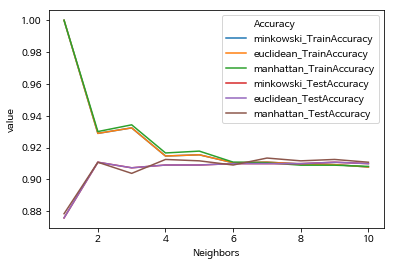

In [33]:
ds_neighbors_weight_melt = pd.melt(ds_neighbors_metric,id_vars=["Neighbors","Metric"])
ds_neighbors_weight_melt["Accuracy"]=ds_neighbors_weight_melt["Metric"]+"_"+ds_neighbors_weight_melt["variable"]
ax = sns.lineplot(x="Neighbors",y="value",hue="Accuracy",data=ds_neighbors_weight_melt)

In [34]:
clf_model = KNeighborsClassifier(n_neighbors=4, weights="uniform",algorithm="ball_tree",metric="euclidean")
clf_model.fit(ds_hmeq_train_x,ds_hmeq_train_y)
print("train data accuracy: {0:.3f}".format(clf.score(ds_hmeq_train_x,ds_hmeq_train_y)))
print("test data accuracy: {0:.3f}".format(clf.score(ds_hmeq_test_x,ds_hmeq_test_y)))

train data accuracy: 0.908
test data accuracy: 0.911
